In [37]:
import file_path as fp
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import math
import collections
import os
from tensorflow.contrib.tensorboard.plugins import projector

In [2]:
mobile_data = pd.read_csv(fp.csv_folder+"mobile_data_info_train_competition.csv")

In [6]:
for col in mobile_data.columns.values[3:]:
    print(col, ":", mobile_data[col].unique())

Operating System : [nan  6.  1.  3.  0.  5.  2.  4.]
Features : [nan  0.  4.  2.  5.  6.  3.  1.]
Network Connections : [nan  0.  1.  2.  3.]
Memory RAM : [nan  3.  9.  8.  7.  5.  6.  4.  1.  0.  2.]
Brand : [ 2. 43. 38. 33. 51. 41. 30. 12. 17. 29. nan 55. 16. 46. 52. 13. 47. 22.
  3. 35.  1. 21.  0. 50. 10. 19.  4. 15. 40.  9. 27. 24. 11. 26.  8. 54.
 53.  5. 37. 48.  7. 25. 42. 14. 18. 28. 45. 32. 20. 39.  6. 34. 23. 36.
 31. 49.]
Warranty Period : [nan 13.  2. 11.  3.  8.  5.  1.  7. 10.  6. 12.  9.  4.  0.]
Storage Capacity : [nan  3. 12.  1. 16. 10.  4. 11. 13.]
Color Family : [12. nan 10. 13. 19.  6.  4.  0.  2. 14.  1. 20.  7. 25. 11. 18. 17. 16.
 22. 24.  3. 23.]
Phone Model : [1526.   nan  376.  559. 2120.  716.   94.  715. 1889.  710. 1480. 1888.
 1773.  600. 1605.  586. 2182.  990.  629.  177.  676.  603. 2050.  589.
  835. 1730. 1289.  989. 1250.   19. 2211.  179. 1842.  590.  602. 1402.
 1876.  116. 1874.  585.  402. 1503. 2158.   98.  688. 1981. 1164.  345.
 1477.  851. 

In [9]:
mobile_data[np.isnan(mobile_data["Operating System"])]

,itemid,title,image_path,Operating System,Features,Network Connections,Memory RAM,Brand,Warranty Period,Storage Capacity,Color Family,Phone Model,Camera,Phone Screen Size
0,2346660,apple iphone 4s back glass spare part original...,mobile_image/a9c8f0fdd6587deed197634066cf7eee.jpg,NaN,NaN,NaN,NaN,2.0,NaN,NaN,12.0,1526.0,NaN,NaN
1,2816338,iphone 4s 64gb white,mobile_image/3b9a11608551b11b9330268e0d055e01.jpg,NaN,NaN,NaN,NaN,2.0,NaN,3.0,12.0,NaN,NaN,NaN
2,2847602,samsung sm b310e piton dual sim,mobile_image/1d719e936841a83c165da620f927de68.jpg,NaN,NaN,NaN,NaN,43.0,13.0,NaN,12.0,NaN,NaN,NaN
3,3116949,samsung caramel gt e1272 dual sim 32 mb putih,mobile_image/1d35a74d90df6cf4a02e6a5df9e9ff29.jpg,NaN,NaN,NaN,NaN,43.0,13.0,NaN,12.0,NaN,NaN,NaN
5,4980072,lcd xiaomi redmi 4+touchscreen,mobile_image/504bbab21ede157e6e3f1b93e6b6484c.jpg,NaN,0.0,NaN,NaN,33.0,NaN,NaN,NaN,376.0,NaN,NaN
6,5769008,samsung caramel gt e1272 dual sim 32mb black,mobile_image/e088ca5ebb1ab5ba90a8cff8f9c4f791.jpg,NaN,NaN,NaN,NaN,43.0,13.0,NaN,10.0,NaN,NaN,NaN
7,9503620,iphone 4g 8gb,mobile_image/a23f0381039e5595559be27db3271d2f.jpg,NaN,NaN,0.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
8,17937158,blackberry torch 1 9800 gsm garansi distributo...,mobile_image/7803e0e63b5972e14b6ff564679f941c.jpg,NaN,0.0,NaN,NaN,51.0,2.0,NaN,12.0,NaN,NaN,NaN
9,21715801,samsung keystone 3 sm b109e,mobile_image/a5360d928a586de4b7dc5a8463f9fc26.jpg,NaN,NaN,1.0,NaN,43.0,NaN,NaN,NaN,559.0,NaN,NaN
10,26702248,samsung galaxy j5 j 500g 8 gb hitam,mobile_image/33d417fc851c7f1704caf6de74d48c0f.jpg,NaN,NaN,NaN,3.0,43.0,13.0,NaN,10.0,2120.0,NaN,NaN


In [74]:
vocabulary  = list()
for line in mobile_data.title.values:
  tokens = line.split()
  for token in tokens:
    # remove telephone numbers
    if len(token) > 5 and token.isdigit():
      continue
      
    vocabulary.append(token)
    
print('Data size', len(vocabulary))

Data size 1378780


In [75]:
import collections

vocabulary_size = 10000

def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)
# del vocabulary  # Hint to reduce memory.
print('Most common words', count[1:6])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])
print("length of the dictionary: ", len(reverse_dictionary), "should be smaller than", vocabulary_size)

Most common words [('samsung', 33200), ('promo', 32830), ('garansi', 31128), ('iphone', 27436), ('1', 25020)]
Sample data [55, 4, 249, 255, 128, 4627, 2506, 13, 934, 137] ['apple', 'iphone', '4s', 'back', 'glass', 'spare', 'part', 'original', 'replacement', 'putih']
length of the dictionary:  10000 should be smaller than 10000


In [76]:
data_index = 0

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
  if data_index + span > len(data):
      data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

4 iphone -> 249 4s
4 iphone -> 55 apple
249 4s -> 255 back
249 4s -> 4 iphone
255 back -> 128 glass
255 back -> 249 4s
128 glass -> 4627 spare
128 glass -> 255 back


In [77]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
#   with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
  with tf.name_scope('embeddings'):
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
  with tf.name_scope('weights'):
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size))
    )
  with tf.name_scope('biases'):
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)

  # Construct the SGD optimizer using a learning rate of 1.0.
  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
  saver = tf.train.Saver()

In [25]:
log_dir = "D:/NDSC_2019/tf_logs/"

In [78]:
# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
  # Open a writer to write summaries.
  writer = tf.summary.FileWriter(log_dir, session.graph)

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in range(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val

    # Add returned summaries to writer in each step.
    writer.add_summary(summary, step)
    # Add metadata to visualize the graph for the last run.
    if step == (num_steps - 1):
      writer.add_run_metadata(run_metadata, 'step%d' % step)

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s: %s' % (valid_word, ", ".join([reverse_dictionary[k] for k in nearest]))
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

  # Write corresponding labels for the embeddings.
  with open(log_dir + '/metadata.tsv', 'w') as f:
    for i in range(vocabulary_size):
      f.write(reverse_dictionary[i] + '\n')

  # Save the model for checkpoints.
  saver.save(session, os.path.join(log_dir, 'model.ckpt'))

  # Create a configuration for visualizing embeddings with the labels in TensorBoard.
  config = projector.ProjectorConfig()
  embedding_conf = config.embeddings.add()
  embedding_conf.tensor_name = embeddings.name
  embedding_conf.metadata_path = os.path.join(log_dir, 'metadata.tsv')
  projector.visualize_embeddings(writer, config)

writer.close()

Initialized
Average loss at step  0 :  238.8485565185547
Nearest to hitam: 18:9, tested, gel, t5e, trimakasih, flexible, vdes, gokil
Nearest to original: keluaran, 3000, distirbutor, roswheel, a5, 7304i, switch, lastlashop
Nearest to sale: bergambar, yb1, big..ramadhan, whatsapp:082192599804, 3.8, original.bm, menjau, sali
Nearest to 6gb: kendala, bagus, f9pro, v11, lumix, 300ppi, m36, c22
Nearest to big: motorolla, lite, bro, s7a, iph, projector, 6020, 301e
Nearest to nokia: retina, 0838, 553kl, j200, cherry, capo, silahkanka, dmi
Nearest to red: 840, th, pelayanan, join, s50h, 2833, glowing, 550kl
Nearest to indonesia: x557, senin, 1329, px470, makasih, lariss, m3z, bls
Nearest to diskon: leopard, xba, x550, lot, b41, redmi2, lapak, ebony
Nearest to rom: without, dikon, backbeat, ori, garansiresmi, trend, handfone, t1r
Nearest to sein: starwars, ck330is, 1900, raugee, j250, unboxing, handfone, electronic
Nearest to vivo: 4238, e500, polymer, sc02, 20000mah, x360, tg, eg680
Nearest to

Average loss at step  52000 :  3.4544918450117112
Average loss at step  54000 :  3.444941231250763
Average loss at step  56000 :  3.4445564436912535
Average loss at step  58000 :  3.438568088889122
Average loss at step  60000 :  3.4309597024917604
Nearest to hitam: putih, merah, original, n920i, b9900, 5.6, white, termurah
Nearest to original: ori, hitam, termurah, putih, UNK, sein, celullar, noncrack
Nearest to sale: promo, salee, menjau, p9983, big..ramadhan, producttt, ramadan, t1l
Nearest to 6gb: 4gb, kendala, v11, 3gb, 6, f7, lumix, f5
Nearest to big: spesial, beli, khusus, cuci, samsung, bro, eu, minat
Nearest to nokia: iphone, oneplus, titanium, 3444, iflash, 0838, 3678, custome
Nearest to red: black, blue, gold, pink, 840, 9241, silver, join
Nearest to indonesia: tam, resmi, tahun, 1th, 1, md101, sein, mtx
Nearest to diskon: discon, termurah, leopard, ekstra, terlaris, festival, grats, promo
Nearest to rom: internal, ram, 6006, apollo, int, trend, room, kyocera
Nearest to sein:

[]

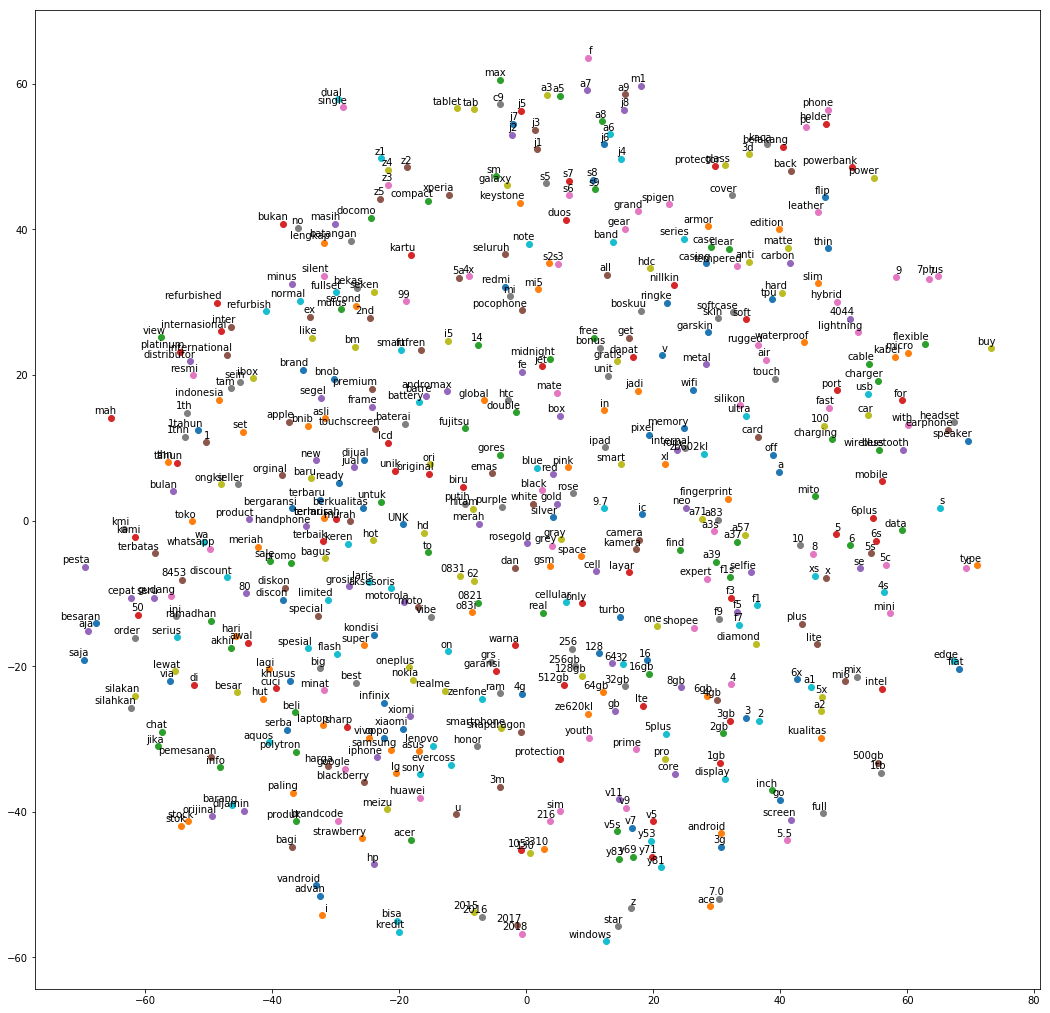

In [79]:
# Step 6: Visualize the embeddings.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]

def plot_with_labels(low_dim_embs, labels):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
  return plt

plot_with_labels(low_dim_embs, labels).plot()

In [10]:
from PIL import Image

In [11]:
im = Image.open(fp.image_base_folder+"mobile_image/70e0d8ddd69692b0f134498efbddf4e1.jpg")

In [12]:
print(im.format, im.size, im.mode)

JPEG (640, 640) RGB
